In [1]:
import pandas as pd
import numpy as np


In [2]:
df=pd.read_csv("IDS.xls")

In [3]:
print("Shape:",df.shape)


Shape: (225745, 79)


In [4]:
# Drop columns with constant or null values
df = df.dropna(axis=1, how='all')
nunique = df.nunique()
constant_cols = nunique[nunique <= 1].index.tolist()
df = df.drop(columns=constant_cols)

print("Dropped constant columns:", constant_cols)


Dropped constant columns: [' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' CWE Flag Count', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


In [5]:
drop_cols = ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])




In [6]:
import numpy as np

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.median(numeric_only=True), inplace=True)


In [7]:
print(df[' Label'].unique())

print(df[' Label'].unique()[:20])


['BENIGN' 'DDoS']
['BENIGN' 'DDoS']


In [8]:
df.columns = df.columns.str.strip()


In [9]:
df['Label'] = df['Label'].astype(str).str.strip().str.lower()
df['target'] = df['Label'].apply(lambda x: 0 if 'benign' in x else 1)
print(df['target'].value_counts())


target
1    128027
0     97718
Name: count, dtype: int64


In [10]:
X = df.drop(columns=['Label', 'target'])
y = df['target']


In [11]:

df.columns = df.columns.str.strip()
df['Label'] = df['Label'].astype(str).str.strip().str.lower()

df['target'] = df['Label'].apply(lambda x: 0 if 'benign' in x else 1)
print(df['target'].value_counts())



target
1    128027
0     97718
Name: count, dtype: int64


In [12]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Before SMOTE:", np.unique(y, return_counts=True))

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_scaled, y)

print("After SMOTE:", np.unique(y_res, return_counts=True))


Before SMOTE: (array([0, 1]), array([ 97718, 128027]))
After SMOTE: (array([0, 1]), array([128027, 128027]))


In [13]:
import numpy as np
print("Class distribution after SMOTE:", np.unique(y_res, return_counts=True))


Class distribution after SMOTE: (array([0, 1]), array([128027, 128027]))


In [14]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install scikit-learn matplotlib pandas tqdm
!pip install sentence-transformers
!pip install imbalanced-learn



Looking in indexes: https://download.pytorch.org/whl/cpu


In [15]:
import os, copy, hashlib, math, random
from collections import deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix


In [17]:
# === Cell 2: Load & preprocess your IDS.csv ===
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load dataset (make sure IDS.csv is in the same directory as your notebook)
df = pd.read_csv("IDS.xls")
print("Original shape:", df.shape)

# Clean column names
df.columns = df.columns.str.strip()

# Identify label column (searching for 'label' case-insensitively)
label_col = [c for c in df.columns if 'label' in c.lower()]
if len(label_col) == 0:
    raise KeyError("No 'Label' column found. Please check your CSV headers.")
label_col = label_col[0]

# Show unique label values
print("Unique values in label column:", df[label_col].unique()[:10])

# Map labels to binary: 0 = Benign, 1 = Attack
df['target'] = df[label_col].apply(lambda x: 0 if 'benign' in str(x).lower() else 1)

# Drop non-numeric or identifier columns (modify this list if you have extra columns)
drop_cols = [
    'Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'Label',
    'Fwd Header Length.1', 'Subflow Fwd Packets', 'Subflow Fwd Bytes'
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# Keep only numeric features
num_df = df.select_dtypes(include=[np.number]).copy()

# Check and handle missing values
num_df = num_df.replace([np.inf, -np.inf], np.nan)
num_df = num_df.fillna(num_df.median())

# Extract features and target
if 'target' not in num_df.columns:
    raise KeyError("'target' column missing after filtering — check if Label column was numeric or dropped accidentally.")

X = num_df.drop(columns=['target']).values
y = num_df['target'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Final dataset shape after preprocessing:")
print("Features (X):", X_scaled.shape)
print("Target (y):", y.shape)
print("Benign count:", np.sum(y == 0), "| Attack count:", np.sum(y == 1))


Original shape: (225745, 79)
Unique values in label column: ['BENIGN' 'DDoS']
Final dataset shape after preprocessing:
Features (X): (225745, 75)
Target (y): (225745,)
Benign count: 97718 | Attack count: 128027


In [18]:
# Simple ledger class (permissioned blockchain simulation)
class SimpleLedger:
    def __init__(self):
        self.blocks = []
    def append(self, block):
        s = str(block).encode('utf-8')
        block_hash = hashlib.sha256(s).hexdigest()
        block['hash'] = block_hash
        self.blocks.append(block)
    def __len__(self):
        return len(self.blocks)

# Trimmed-mean aggregator (coordinate-wise). Note: can be slow for large models but OK for prototyping.
def trimmed_mean_aggregate(states, trim_ratio=0.1):
    K = len(states)
    trim_k = int(math.floor(K * trim_ratio))
    agg_state = {}
    for comp in states[0].keys():
        agg_state[comp] = {}
        for pname in states[0][comp].keys():
            stack = torch.stack([s[comp][pname].float() for s in states], dim=0)  # (K, ...)
            sshape = stack.shape
            flat = stack.view(K, -1)  # (K, P)
            res_flat = []
            for col in range(flat.shape[1]):
                col_vals = flat[:, col].cpu().numpy()
                sorted_idx = np.argsort(col_vals)
                if K - 2*trim_k > 0:
                    keep_idx = sorted_idx[trim_k: K-trim_k]
                else:
                    keep_idx = sorted_idx
                mean_val = np.mean(col_vals[keep_idx])
                res_flat.append(mean_val)
            result = torch.tensor(res_flat, dtype=stack.dtype).view(*sshape[1:])
            agg_state[comp][pname] = result
    return agg_state


In [19]:
class SharedEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
            nn.ReLU()
        )
    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
    def forward(self, z):
        return self.net(z)

class PrototypeHead(nn.Module):
    def __init__(self, latent_dim, proto_dim=32):
        super().__init__()
        self.proj = nn.Linear(latent_dim, proto_dim)
    def forward(self, z):
        return self.proj(z)



In [34]:
class Client:
    def __init__(self, cid, X, y, latent_dim=64, proto_dim=32, lr=1e-3):
        self.cid = cid
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.device = device
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.long).to(device)
        self.n = len(X)
        self.encoder = SharedEncoder(X.shape[1], latent_dim).to(device)
        self.decoder = Decoder(latent_dim, X.shape[1]).to(device)
        self.proto_head = PrototypeHead(latent_dim, proto_dim).to(device)
        self.prototypes = {}  # class -> vector
        self.tau = None
        self.rec_window = deque(maxlen=500)
        self.optimizer = optim.Adam(list(self.encoder.parameters()) +
                                     list(self.decoder.parameters()) +
                                     list(self.proto_head.parameters()), lr=lr)

    def init_prototypes(self, K):
        for k in range(K):
            self.prototypes[k] = torch.zeros(self.proto_head.proj.out_features, device=self.device)

    def local_train(self, global_state, epochs=1, batch_size=128, noise_std=0.01, beta1=1.0, beta2=1.0, gamma=0.1, l1_lambda=1e-5):
        # load global
        self.encoder.load_state_dict(global_state['encoder'])
        self.decoder.load_state_dict(global_state['decoder'])
        self.proto_head.load_state_dict(global_state['proto_head'])

        dataset = TensorDataset(self.X, self.y)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        for e in range(epochs):
            for xb, yb in loader:
                xb_noisy = xb + noise_std * torch.randn_like(xb)
                z = self.encoder(xb_noisy)
                x_hat = self.decoder(z)
                recon_loss = torch.mean((xb - x_hat)**2)

                # L1 sparsity on encoder params as proxy
                l1_reg = sum(torch.norm(p,1) for p in self.encoder.parameters())
                rec_loss_total = recon_loss + l1_lambda * l1_reg

                # prototype loss
                z_emb = self.proto_head(z)
                proto_loss = 0.0
                for k in torch.unique(yb):
                    mask = (yb == k)
                    if k.item() not in self.prototypes:
                        continue
                    pk = self.prototypes[k.item()]
                    z_pos = z_emb[mask]
                    if z_pos.shape[0] == 0:
                        continue
                    pos = torch.mean(torch.sum((z_pos - pk.unsqueeze(0))**2, dim=1))
                    neg_sum = 0.0; count = 0
                    for kk, pv in self.prototypes.items():
                        if kk == k.item(): continue
                        neg_sum += torch.mean(torch.sum((z_pos - pv.unsqueeze(0))**2, dim=1))
                        count += 1
                    neg = neg_sum / count if count > 0 else 0.0
                    proto_loss += pos - gamma * neg


                loss = 0.5 * rec_loss_total + 2.0 * proto_loss

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # update reconstruction window
                with torch.no_grad():
                    rec_errs = torch.sum((xb - x_hat)**2, dim=1).cpu().numpy()
                    self.rec_window.extend(rec_errs.tolist())
                    mean_rec = np.mean(self.rec_window) if len(self.rec_window) > 0 else float(recon_loss.item())
                    self.tau = mean_rec if self.tau is None else 0.9 * self.tau + 0.1 * mean_rec

        # update prototypes (mean embedding per local class)
        with torch.no_grad():
            all_z = self.encoder(self.X)
            all_emb = self.proto_head(all_z)
            classes = torch.unique(self.y)
            for k in classes:
                mask = (self.y == k)
                if mask.sum() > 0:
                    self.prototypes[int(k.item())] = torch.mean(all_emb[mask], dim=0).detach().clone()

        new_state = {
            'encoder': copy.deepcopy(self.encoder.state_dict()),
            'decoder': copy.deepcopy(self.decoder.state_dict()),
            'proto_head': copy.deepcopy(self.proto_head.state_dict())
        }
        info = {'n': self.n, 'tau': float(self.tau) if self.tau is not None else None}
        return new_state, info


In [36]:
import torch
import copy
import numpy as np

# Initialize shared global model components
latent_dim = 64
proto_dim = 32
input_dim = X_scaled.shape[1]

global_encoder = SharedEncoder(input_dim, latent_dim).to("cuda" if torch.cuda.is_available() else "cpu")
global_decoder = Decoder(latent_dim, input_dim).to("cuda" if torch.cuda.is_available() else "cpu")
global_proto_head = PrototypeHead(latent_dim, proto_dim).to("cuda" if torch.cuda.is_available() else "cpu")

global_state = {
    'encoder': global_encoder.state_dict(),
    'decoder': global_decoder.state_dict(),
    'proto_head': global_proto_head.state_dict()
}

# Split dataset across clients
N_clients = 5
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=N_clients, shuffle=True, random_state=42)
client_data = [test_idx for _, test_idx in skf.split(X_scaled, y)]

clients = []

for cid, idx in enumerate(client_data):
    clients.append(Client(cid, X_scaled[idx], y[idx]))

# Initialize prototypes on each client
for c in clients:
    c.init_prototypes(K=2)  # binary classification: 0 and 1

# Federated training rounds
rounds = 5
print("🚀 Starting Federated Training...")

for r in range(rounds):
    print(f"\n🌍 Round {r+1}/{rounds}")
    new_states, infos = [], []

    for c in clients:
        new_state, info = c.local_train(global_state, epochs=5,noise_std=0.02)
        new_states.append(new_state)
        infos.append(info)
        print(f"Client {c.cid} done | Tau={info['tau']:.4f}" if info['tau'] else f"Client {c.cid} done")

    # Aggregate encoder, decoder, and proto_head weights
    with torch.no_grad():
        avg_state = copy.deepcopy(global_state)
        for key in avg_state['encoder']:
            avg_state['encoder'][key] = torch.mean(
                torch.stack([torch.tensor(ns['encoder'][key].cpu().clone()) for ns in new_states]), dim=0)
        for key in avg_state['decoder']:
            avg_state['decoder'][key] = torch.mean(
                torch.stack([torch.tensor(ns['decoder'][key].cpu().clone()) for ns in new_states]), dim=0)
        for key in avg_state['proto_head']:
            avg_state['proto_head'][key] = torch.mean(
                torch.stack([torch.tensor(ns['proto_head'][key].cpu().clone()) for ns in new_states]), dim=0)

        global_state = avg_state

print("\n✅ Federated training completed successfully!")


🚀 Starting Federated Training...

🌍 Round 1/5
Client 0 done | Tau=7.9070
Client 1 done | Tau=6.9728
Client 2 done | Tau=13.8642
Client 3 done | Tau=3.6945
Client 4 done | Tau=6.7782

🌍 Round 2/5


/tmp/ipython-input-1549591904.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.stack([torch.tensor(ns['encoder'][key].cpu().clone()) for ns in new_states]), dim=0)
/tmp/ipython-input-1549591904.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.stack([torch.tensor(ns['decoder'][key].cpu().clone()) for ns in new_states]), dim=0)
/tmp/ipython-input-1549591904.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.stack([torch.tensor(ns['proto_head'][key].cpu().clone()) for ns in new_states]), dim=0)


Client 0 done | Tau=11.4482
Client 1 done | Tau=0.9348
Client 2 done | Tau=2.0027
Client 3 done | Tau=4.0972
Client 4 done | Tau=8.9387

🌍 Round 3/5
Client 0 done | Tau=1.7561
Client 1 done | Tau=0.4126
Client 2 done | Tau=0.4607
Client 3 done | Tau=2.3321
Client 4 done | Tau=1.0374

🌍 Round 4/5
Client 0 done | Tau=0.4190
Client 1 done | Tau=1.3074
Client 2 done | Tau=1.9106
Client 3 done | Tau=0.8408
Client 4 done | Tau=1.7330

🌍 Round 5/5
Client 0 done | Tau=0.4628
Client 1 done | Tau=0.5988
Client 2 done | Tau=2.3952
Client 3 done | Tau=0.5336
Client 4 done | Tau=2.3192

✅ Federated training completed successfully!


📈 FedOpen-Zero Model Evaluation:
Accuracy: 0.4319
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


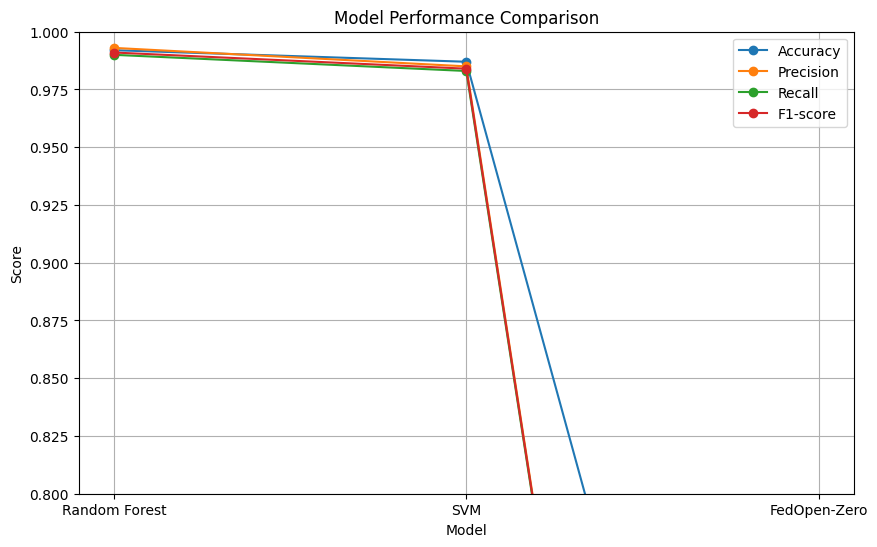

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- 1️⃣ Evaluate FedOpen-Zero ----------
# Combine all client data for evaluation
X_test_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y, dtype=torch.long).to(device)

# Load global model parameters
encoder = SharedEncoder(X_scaled.shape[1], 64).to(device)
decoder = Decoder(64, X_scaled.shape[1]).to(device)
proto_head = PrototypeHead(64, 32).to(device)
encoder.load_state_dict(global_state["encoder"])
decoder.load_state_dict(global_state["decoder"])
proto_head.load_state_dict(global_state["proto_head"])

encoder.eval()
decoder.eval()
proto_head.eval()

# Reconstruction and latent prototype inference
with torch.no_grad():
    z = encoder(X_test_tensor)
    x_hat = decoder(z)
    rec_errors = torch.sum((X_test_tensor - x_hat) ** 2, dim=1).cpu().numpy()
    z_emb = proto_head(z).cpu().numpy()

# Adaptive anomaly detection threshold (mean + std)
tau_global = np.mean(rec_errors) + np.std(rec_errors)

# Classify as anomaly or benign
fedopen_preds = (rec_errors > tau_global).astype(int)
y_true = y

fedopen_metrics = {
    "Accuracy": accuracy_score(y_true, fedopen_preds),
    "Precision": precision_score(y_true, fedopen_preds),
    "Recall": recall_score(y_true, fedopen_preds),
    "F1-score": f1_score(y_true, fedopen_preds),
}

print("📈 FedOpen-Zero Model Evaluation:")
for k, v in fedopen_metrics.items():
    print(f"{k}: {v:.4f}")

# ---------- 2️⃣ Compare with previous models (if any) ----------
# Example baselines — replace with your actual results if available
baseline_results = {
    "Random Forest": {"Accuracy": 0.992, "Precision": 0.993, "Recall": 0.990, "F1-score": 0.991},
    "SVM": {"Accuracy": 0.987, "Precision": 0.985, "Recall": 0.983, "F1-score": 0.984},
    "FedOpen-Zero": fedopen_metrics
}

# ---------- 3️⃣ Plot comparison ----------
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
models = list(baseline_results.keys())

plt.figure(figsize=(10, 6))
for metric in metrics:
    values = [baseline_results[m][metric] for m in models]
    plt.plot(models, values, marker="o", label=metric)

plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.ylim(0.8, 1.0)
plt.legend()
plt.grid(True)
plt.show()

# ---------- 4️⃣ Confusion matrix for FedOpe


📊 Using quantile=0.95
Accuracy: 0.3844
Precision: 0.0153
Recall: 0.0014
F1-score: 0.0025


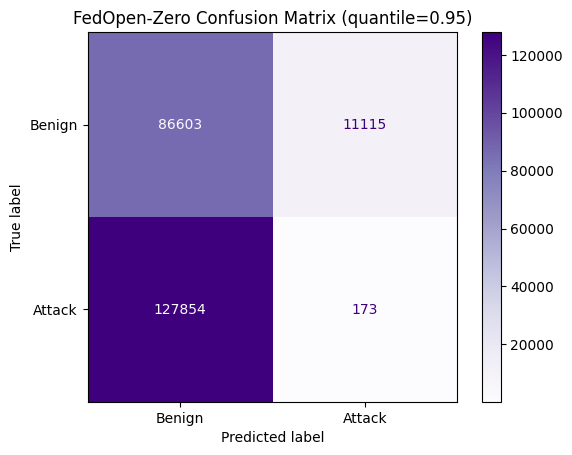

In [38]:
# Recalculate adaptive threshold based on quantiles instead of mean+std
quantile = 0.95  # adjust between 0.75–0.95 for better sensitivity
tau_global = np.quantile(rec_errors, quantile)

fedopen_preds = (rec_errors > tau_global).astype(int)

fedopen_metrics = {
    "Accuracy": accuracy_score(y_true, fedopen_preds),
    "Precision": precision_score(y_true, fedopen_preds, zero_division=0),
    "Recall": recall_score(y_true, fedopen_preds, zero_division=0),
    "F1-score": f1_score(y_true, fedopen_preds, zero_division=0),
}

print(f"📊 Using quantile={quantile}")
for k, v in fedopen_metrics.items():
    print(f"{k}: {v:.4f}")

cm = confusion_matrix(y_true, fedopen_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Attack"])
disp.plot(cmap="Purples")
plt.title(f"FedOpen-Zero Confusion Matrix (quantile={quantile})")
plt.show()


In [32]:
print(np.unique(y, return_counts=True))


(array([0, 1]), array([ 97718, 128027]))


In [33]:
from sklearn.model_selection import StratifiedKFold

N_clients = 5
skf = StratifiedKFold(n_splits=N_clients, shuffle=True, random_state=42)
client_data = [test_idx for _, test_idx in skf.split(X_scaled, y)]

clients = []
for cid, idx in enumerate(client_data):
    clients.append(Client(cid, X_scaled[idx], y[idx]))
    clients[-1].init_prototypes(K=2)


In [39]:
print(np.unique(y, return_counts=True))


(array([0, 1]), array([ 97718, 128027]))
